<a href="https://www.kaggle.com/code/arnabmathjee/loan-approval-project?scriptVersionId=224235381" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
import lightgbm as lgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

from scipy.stats import chi2_contingency
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv


In [3]:
df1=pd.read_csv('/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv')

In [4]:
df1.columns=[column.strip() for column in df1.columns]

In [5]:
df1.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status'],
      dtype='object')

# Exploratory Data Analysis

In [6]:
df1.isna().sum()

loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

In [7]:
df1['loan_status'] = df1['loan_status'].str.strip().apply(lambda x: {'Approved': 1, 'Rejected': 0}[x])



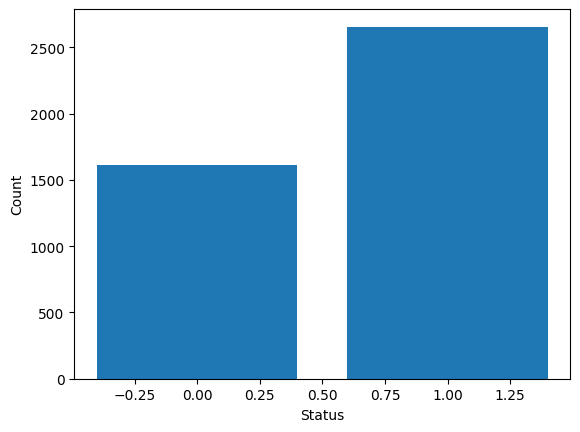

In [8]:
###1) Checking for biaseness in output class
# Count the values of loan status
y = df1['loan_status'].value_counts()

# Plotting
plt.bar(y.index, y.values, width=0.8)
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [9]:
df1['education'].value_counts()

education
Graduate        2144
Not Graduate    2125
Name: count, dtype: int64

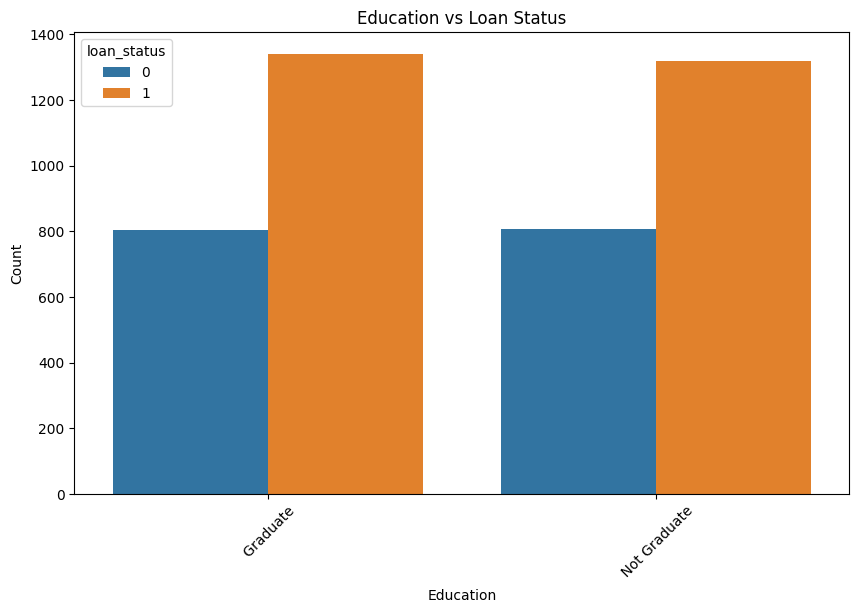

In [10]:
plt.figure(figsize=(10,6))
sns.countplot(x='education', hue='loan_status', data=df1)

# Customize the plot
plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Education vs Loan Status')
plt.xticks(rotation=45)  # Rotate the x labels if needed
plt.show()

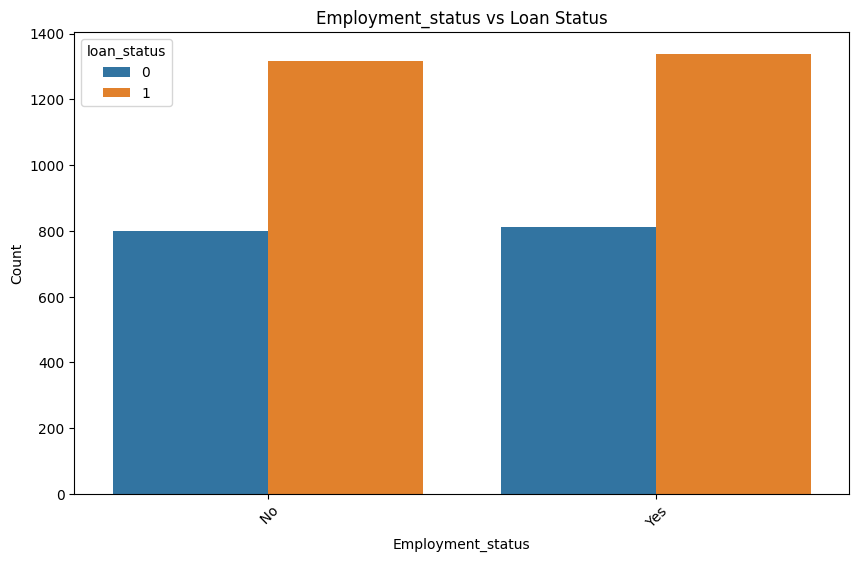

In [11]:
plt.figure(figsize=(10,6))
sns.countplot(x='self_employed', hue='loan_status', data=df1)

# Customize the plot
plt.xlabel('Employment_status')
plt.ylabel('Count')
plt.title('Employment_status vs Loan Status')
plt.xticks(rotation=45)  # Rotate the x labels if needed
plt.show()

### Visuals show that education and employment are not that important factors in predicting loan approval status. So now lets confirm it using statistical tests


In [12]:



# Create a contingency table
contingency_table = pd.crosstab(df1['education'], df1['loan_status'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")


Chi-Square Statistic: 0.08395754138250573
p-value: 0.7720042291016309


In [13]:
# Create a contingency table
contingency_table = pd.crosstab(df1['self_employed'], df1['loan_status'])

# Perform Chi-Square test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Output the results
print(f"Chi-Square Statistic: {chi2}")
print(f"p-value: {p}")


Chi-Square Statistic: 0.0
p-value: 1.0


#### the chi-square test indeed proofes our assertion


# Numeric Feature EDA

### From here we begin exploring trends of loan request being accepted or rejected vs the numeric features


In [14]:
df1[['income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status']].describe()

,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


### Easy feature scaling. We basically bring all numbers in one scale for easy analysis

In [15]:
df1['income_annum']=df1['income_annum']/(10**5)
df1['loan_amount']=df1['loan_amount']/(10**5)
df1['residential_assets_value']=df1['residential_assets_value']/(10**5)
df1['commercial_assets_value']=df1['commercial_assets_value']/(10**5)
df1['luxury_assets_value']=df1['luxury_assets_value']/(10**5)
df1['bank_asset_value']=df1['bank_asset_value']/(10**5)

In [16]:
df1

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,96.0,299.0,12,778,24.0,176.0,227.0,80.0,1
1,2,0,Not Graduate,Yes,41.0,122.0,8,417,27.0,22.0,88.0,33.0,0
2,3,3,Graduate,No,91.0,297.0,20,506,71.0,45.0,333.0,128.0,0
3,4,3,Graduate,No,82.0,307.0,8,467,182.0,33.0,233.0,79.0,0
4,5,5,Not Graduate,Yes,98.0,242.0,20,382,124.0,82.0,294.0,50.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4264,4265,5,Graduate,Yes,10.0,23.0,12,317,28.0,5.0,33.0,8.0,0
4265,4266,0,Not Graduate,Yes,33.0,113.0,20,559,42.0,29.0,110.0,19.0,1
4266,4267,2,Not Graduate,No,65.0,239.0,18,457,12.0,124.0,181.0,73.0,0
4267,4268,1,Not Graduate,No,41.0,128.0,8,780,82.0,7.0,141.0,58.0,1


/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_

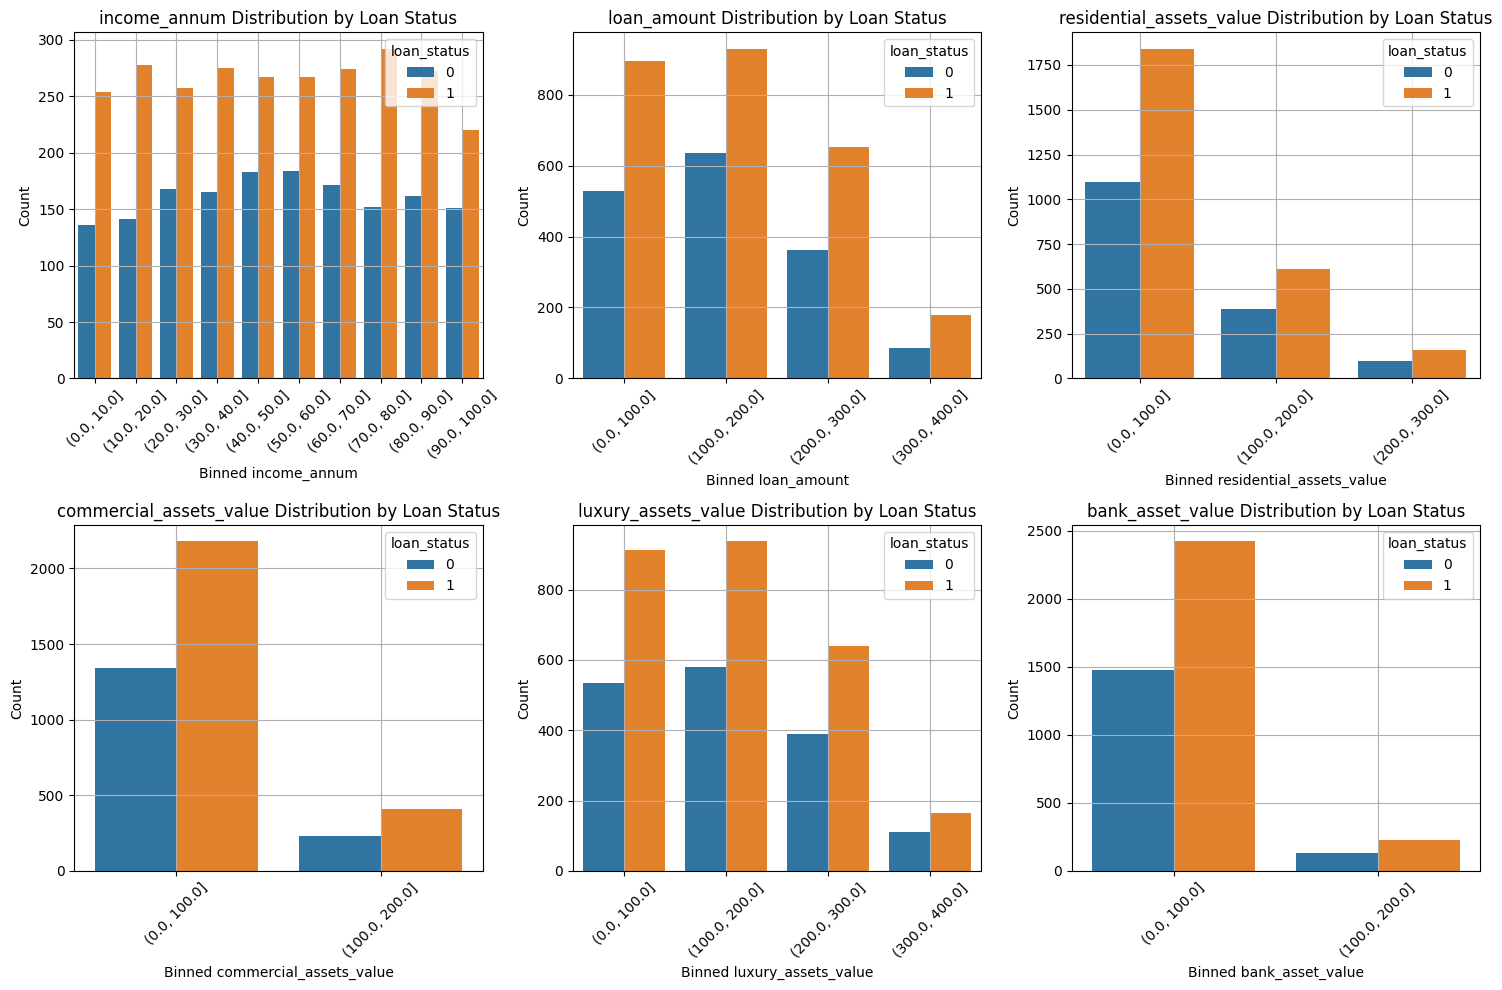

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# List of columns to plot
columns = [
    'income_annum',
    'loan_amount',
    'residential_assets_value',
    'commercial_assets_value',
    'luxury_assets_value',
    'bank_asset_value'
]

# Create count plots for each column
plt.figure(figsize=(15, 10))

for i, col in enumerate(columns, 1):
    plt.subplot(2, 3, i)  # Adjust the grid size if necessary
    
    # Determine bin size based on max value
    max_val = df1[col].max()
    if max_val < 100:
        bins = np.arange(0, max_val + 10, 10)
    elif max_val < 1000:
        bins = np.arange(0, max_val + 100, 100)
    else:
        bins = np.arange(0, max_val + 1000, 1000)
    
    # Create a new column for binned data
    df1[f'{col}_binned'] = pd.cut(df1[col], bins=bins)
    
    # Plot count plot for the binned data
    sns.countplot(x=df1[f'{col}_binned'], hue=df1['loan_status'])
    plt.xlabel(f'Binned {col}')
    plt.ylabel('Count')
    plt.title(f'{col} Distribution by Loan Status')
    plt.xticks(rotation=45)
    plt.grid(True)

plt.tight_layout()
plt.show()


### Even after scaling, we get three datapoints which are still left skewed. This shows we need to remove outliers for these features only now.

In [18]:
features_to_clean = [
    'residential_assets_value',
    'commercial_assets_value',
    'bank_asset_value'
]

# Function to remove outliers using IQR method
def remove_outliers(df, feature):
    Q1 = df[feature].quantile(0.25)
    Q3 = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]

# Apply outlier removal to each feature

for feature in features_to_clean:
    df1_cleaned= remove_outliers(df1, feature)

# Check the shape of the cleaned DataFrame
print(f"Original DataFrame shape: {df1.shape}")
print(f"Cleaned DataFrame shape: {df1_cleaned.shape}")

Original DataFrame shape: (4269, 19)
Cleaned DataFrame shape: (4264, 19)


# EDA is done. Now let's start model building. We will test various models and their accuracy over this classification task.

In [19]:
df1.columns

Index(['loan_id', 'no_of_dependents', 'education', 'self_employed',
       'income_annum', 'loan_amount', 'loan_term', 'cibil_score',
       'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value', 'loan_status',
       'income_annum_binned', 'loan_amount_binned',
       'residential_assets_value_binned', 'commercial_assets_value_binned',
       'luxury_assets_value_binned', 'bank_asset_value_binned'],
      dtype='object')

In [20]:
df1.drop(columns=['education', 'self_employed'],axis=1,inplace=True)

In [21]:
#X=df1.drop(columns=['loan_id','loan_status',],axis=1)
X=df1.drop(columns=['loan_id','loan_amount_binned', 'residential_assets_value_binned',
       'commercial_assets_value_binned', 'luxury_assets_value_binned',
       'bank_asset_value_binned','income_annum_binned','loan_status'])

y=df1['loan_status']

In [22]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)

In [23]:
X

,no_of_dependents,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value
0,2,96.0,299.0,12,778,24.0,176.0,227.0,80.0
1,0,41.0,122.0,8,417,27.0,22.0,88.0,33.0
2,3,91.0,297.0,20,506,71.0,45.0,333.0,128.0
3,3,82.0,307.0,8,467,182.0,33.0,233.0,79.0
4,5,98.0,242.0,20,382,124.0,82.0,294.0,50.0
...,...,...,...,...,...,...,...,...,...
4264,5,10.0,23.0,12,317,28.0,5.0,33.0,8.0
4265,0,33.0,113.0,20,559,42.0,29.0,110.0,19.0
4266,2,65.0,239.0,18,457,12.0,124.0,181.0,73.0
4267,1,41.0,128.0,8,780,82.0,7.0,141.0,58.0


In [24]:
y

0       1
1       0
2       0
3       0
4       0
       ..
4264    0
4265    1
4266    0
4267    1
4268    1
Name: loan_status, Length: 4269, dtype: int64

In [25]:
lr=LogisticRegression()
rf=RandomForestClassifier()
xgb=XGBClassifier()


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72       328
           1       0.80      0.93      0.86       526

    accuracy                           0.81       854
   macro avg       0.82      0.78      0.79       854
weighted avg       0.82      0.81      0.81       854

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       328
           1       0.98      0.98      0.98       526

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98       328
           1       0.98      0.99      0.99       526

    accuracy                           0.98       854
   macro avg     

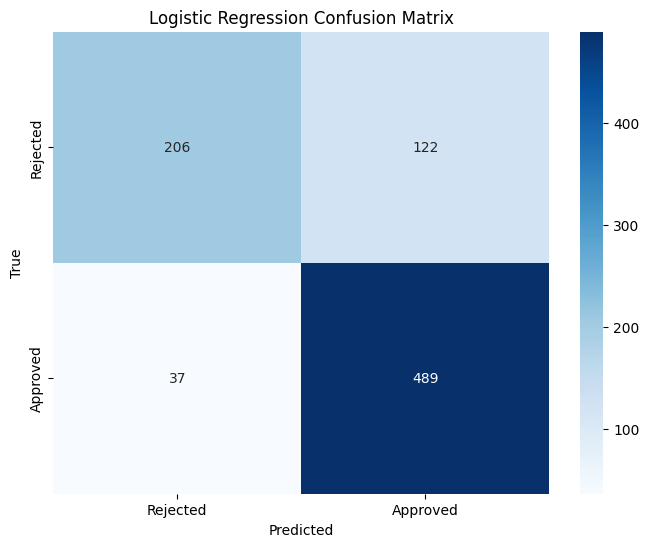

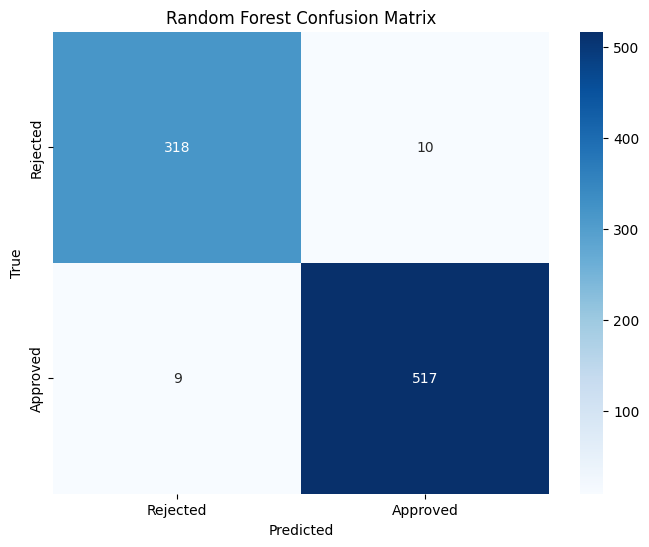

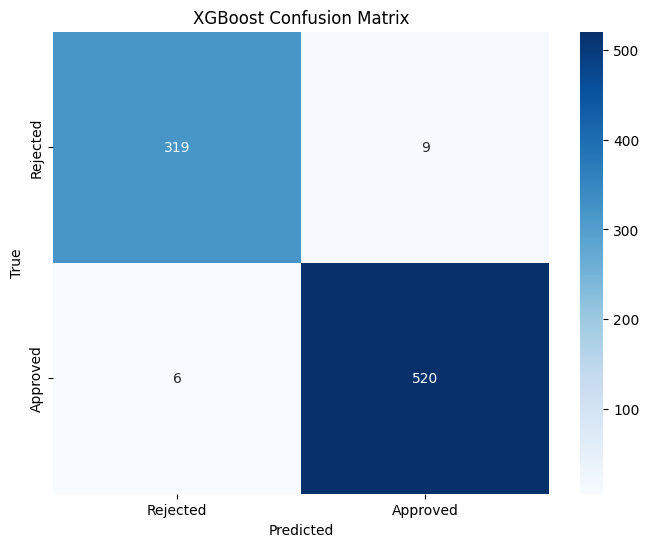

In [26]:
lr.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

# Predict on test set
lr_pred = lr.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)

# Print classification reports
print("Logistic Regression Classification Report:")
print(classification_report(y_test, lr_pred))
print("Random Forest Classification Report:")
print(classification_report(y_test, rf_pred))
print("XGBoost Classification Report:")
print(classification_report(y_test, xgb_pred))

# Print confusion matrices
lr_cm = confusion_matrix(y_test, lr_pred)
rf_cm = confusion_matrix(y_test, rf_pred)
xgb_cm = confusion_matrix(y_test, xgb_pred)

print("Logistic Regression Confusion Matrix:")
print(lr_cm)
print("Random Forest Confusion Matrix:")
print(rf_cm)
print("XGBoost Confusion Matrix:")
print(xgb_cm)

# Plot confusion matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Rejected', 'Approved'], 
                yticklabels=['Rejected', 'Approved'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

plot_confusion_matrix(lr_cm, "Logistic Regression Confusion Matrix")
plot_confusion_matrix(rf_cm, "Random Forest Confusion Matrix")
plot_confusion_matrix(xgb_cm, "XGBoost Confusion Matrix")

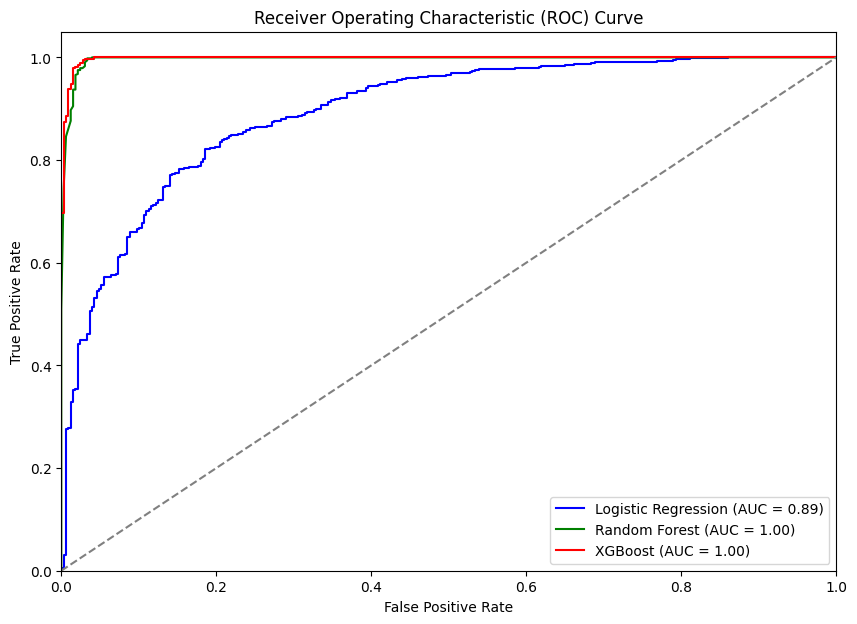

In [27]:
lr_probs = lr.predict_proba(X_test)[:, 1]
rf_probs = rf.predict_proba(X_test)[:, 1]
xgb_probs = xgb.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC for each model
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)

lr_auc = auc(lr_fpr, lr_tpr)
rf_auc = auc(rf_fpr, rf_tpr)
xgb_auc = auc(xgb_fpr, xgb_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 7))
plt.plot(lr_fpr, lr_tpr, color='blue', label=f'Logistic Regression (AUC = {lr_auc:.2f})')
plt.plot(rf_fpr, rf_tpr, color='green', label=f'Random Forest (AUC = {rf_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, color='red', label=f'XGBoost (AUC = {xgb_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

# Cross-Validation for Random Forest
rf_cv_scores = cross_val_score(rf, X, y, cv=5, scoring='roc_auc')
print(f'Random Forest Cross-Validated AUC: {np.mean(rf_cv_scores):.2f}')

# Cross-Validation for XGBoost
xgb_cv_scores = cross_val_score(xgb, X, y, cv=5, scoring='roc_auc')
print(f'XGBoost Cross-Validated AUC: {np.mean(xgb_cv_scores):.2f}')


Random Forest Cross-Validated AUC: 1.00
XGBoost Cross-Validated AUC: 1.00


In [29]:
X.columns

Index(['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term',
       'cibil_score', 'residential_assets_value', 'commercial_assets_value',
       'luxury_assets_value', 'bank_asset_value'],
      dtype='object')